In [1]:
# importing the libraries
import numpy as np
import peakutils
import syntheticdata
import threegaussians
import lorentzian
from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate
from astropy.modeling import models, fitting
import pandas as pd

In [7]:
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

In [22]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [10]:
# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

In [3]:
def Earth_Smoothing(nm_array, y_array,noise_coefficient):        
    """
    ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    from pyearth import Earth
   # Fit an Earth model
    model = Earth(smooth=True)
    np.random.seed(42)
    ydata = y_array + noise_coefficient*np.random.normal(size=nm_array.size)
    model.fit(nm_array, ydata)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

* py-earth

In [4]:
def earth_smooth_matrix(nm_array,data_matrix,noise_coefficient):
    num_array = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(500):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array = Earth_Smoothing(nm_array,data_array,noise_coefficient).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')
        
    return noise_matx, smooth_matx

In [12]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices

In [2]:
def Earth_Peakutils(nm_array, timedelay,threshold,min_dist):
    import numpy
    import matplotlib.pyplot as plt
    from pyearth import Earth
    
    """
     ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    # Create some fake data
    # generate some noisy data from syntheticdata:
    np.random.seed(1729)
    y_noise = 0.1 * np.random.normal(size=nm_array.size)
    ydata = timedelay + y_noise
    
   # Fit an Earth model
    model = Earth(max_degree=2, minspan_alpha=.5, smooth=True)
    model.fit(nm_array, ydata)
    
   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
   
    # use peakutils to find peak indexs
    peak_indices_true = peakutils.indexes(timedelay, thres=threshold, min_dist=min_dist)
    peak_indices_smooth = peakutils.indexes(y_hat, thres=threshold, min_dist=min_dist)
    
    return peak_indices_true,peak_indices_smooth
    

In [13]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(500):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

# -------------------------------------------------------------------------------------------
# * Get peak dataframe

In [8]:
matx_filename = '20180418_twogaussian_spectralshfit.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)


In [11]:
noisez_matx, smooth_matx = earth_smooth_matrix(datanm,dataz_matx,0.1)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


* py-earth and peakutils 

In [14]:
## get the peak position dataframe of true data set
true_df, smooth_df = earth_peak_matrix(datanm, dataz_matx, 0.1, 0, 10)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [15]:
true_df

,0,1
0,50,400
1,50,400
2,50,400
3,50,400
4,51,400
5,51,400
6,51,400
7,51,400
8,52,400
9,52,400


In [16]:
smooth_df

,0,1,2,3
0,50,402.0,NaN,NaN
1,53,393.0,NaN,NaN
2,54,393.0,NaN,NaN
3,54,394.0,NaN,NaN
4,53,198.0,392.0,NaN
5,55,389.0,NaN,NaN
6,55,389.0,NaN,NaN
7,54,389.0,NaN,NaN
8,54,389.0,NaN,NaN
9,55,213.0,389.0,NaN


# Peak width and fwhm Dataframe

In [17]:
def peakchar(data_nm, data_z_array, peak_index):
    """find the peak width, and intensity"""
    num_peaks = len(peak_index)
    
    #array of peak height
    height = [data_z_array[idx] for idx in peak_index]
    
    #array of peak width
    half_height = [ht / 2 for ht in height]

    fwhm_idx_1 = np.empty_like(half_height)
    fwhm_idx_2 = np.empty_like(fwhm_idx_1)
    fwhm_nm_1 = np.empty_like(fwhm_idx_1)
    fwhm_nm_2 = np.empty_like(fwhm_idx_1)
    
    for i in range(num_peaks):
        #find the index and nmof the left side of the fwhm
        if i == 0:
            fwhm_idx_1[i] = find_nearest(data_z_array[0:peak_index[i]], half_height[i])
        else:
            fwhm_idx_1[i] = find_nearest(data_z_array[peak_index[i-1]:peak_index[i]], half_height[i]) + peak_index[i-1]

        fwhm_nm_1[i] = data_nm[int(fwhm_idx_1[i])]
        
        #find the index and nm of the right side of the fwhm   
        fwhm_idx_2[i] = find_nearest(data_z_array[peak_index[i]:], half_height[i]) + peak_index[i]

        fwhm_nm_2[i] = data_nm[int(fwhm_idx_2[i])]
    
    #find fwhm
    fwhm = fwhm_nm_2 - fwhm_nm_1

    return height, fwhm

In [18]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist)
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

In [19]:
def peak_matrix(nm_array,data_matrix, threshold, mindist):
    """find peaks in a data matrix"""
    peak_idx_matx = []
    peak_height_matx = []
    peak_fwhm_matx = []
    
    for i in range(500):
        data_timeslice = data_matrix.values[:, i]
        
        peak_idx = findpeak(data_timeslice, threshold, mindist).tolist()
        peak_idx_matx.append(peak_idx)
        
        
        peak_height, peak_fwhm = peakchar(nm_array, data_timeslice, peak_idx)
        
        peak_height_matx.append(peak_height)
        peak_fwhm_matx.append(peak_fwhm)
        
        # transfer to dataframe
        peak_idx_df=pd.DataFrame(peak_idx_matx)
        peak_height_df=pd.DataFrame(peak_height_matx)
        peak_fwhm_df=pd.DataFrame(peak_fwhm_matx)
        
    return peak_idx_df, peak_height_df, peak_fwhm_df

In [20]:
smooth_matx.values[:, 200]

array([1.38192229e-01, 1.34475701e-01, 1.30759174e-01, 1.27042646e-01,
       1.23326119e-01, 1.19609591e-01, 1.15893064e-01, 1.12176537e-01,
       1.08774782e-01, 1.05986614e-01, 1.03788096e-01, 1.02155290e-01,
       1.01064261e-01, 1.00491070e-01, 1.00411781e-01, 1.00802456e-01,
       1.01639158e-01, 1.02897951e-01, 1.04554898e-01, 1.06586060e-01,
       1.08967502e-01, 1.11675286e-01, 1.14685475e-01, 1.17974131e-01,
       1.21517319e-01, 1.25291100e-01, 1.29271538e-01, 1.33434696e-01,
       1.37756636e-01, 1.42213422e-01, 1.46781117e-01, 1.51435782e-01,
       1.56153482e-01, 1.60910279e-01, 1.65682237e-01, 1.70445417e-01,
       1.75175883e-01, 1.79849699e-01, 1.84442926e-01, 1.88931628e-01,
       1.93291867e-01, 1.97499708e-01, 2.01623369e-01, 2.05747031e-01,
       2.09870693e-01, 2.13994354e-01, 2.18118016e-01, 2.22241677e-01,
       2.26365339e-01, 2.30489001e-01, 2.34612662e-01, 2.38736324e-01,
       2.42859985e-01, 2.46983647e-01, 2.51107309e-01, 2.55230970e-01,
      

In [23]:
peak_idx_df, peak_height_df, peak_fwhm_df = peak_matrix(datanm,smooth_matx, 0.00, 50)

In [24]:
peak_height_df

,0,1,2
0,0.985774,0.299023,NaN
1,0.996078,0.298428,NaN
2,0.990876,0.295483,NaN
3,0.986697,0.293449,NaN
4,0.980665,0.070503,0.287307
5,0.977614,0.285432,NaN
6,0.972848,0.282623,NaN
7,0.970956,0.279988,NaN
8,0.970788,0.275798,NaN
9,0.957124,0.074204,0.279275


In [25]:
peak_fwhm_df

,0,1,2
0,110.0,354.0,NaN
1,111.0,228.0,NaN
2,111.0,228.0,NaN
3,111.0,225.0,NaN
4,112.0,417.0,232.0
5,110.0,230.0,NaN
6,110.0,360.0,NaN
7,111.0,230.0,NaN
8,110.0,232.0,NaN
9,112.0,404.0,222.0


In [26]:
peak_idx_df

,0,1,2
0,50,402.0,NaN
1,53,393.0,NaN
2,54,393.0,NaN
3,54,394.0,NaN
4,53,198.0,392.0
5,55,389.0,NaN
6,55,389.0,NaN
7,54,389.0,NaN
8,54,389.0,NaN
9,55,213.0,389.0


# --------------------------------------------------------

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
from scipy.special import gamma
from sklearn.cluster import KMeans

In [28]:
def id_outliers_replacewith_interp(x_array, data, m, win_len):
    reshape_x_array = []
    reshape_data = []
    quotient_array = np.empty(len(data))
    remainder_array = np.empty(len(data))
    quotient_array[0] = 0
    remainder_array[0] = 0  
    #print divmod(len(data), win_len)   
    quotient_max = divmod(len(data), win_len)[0]
    print (quotient_max)
    #quotient_array_new = []
    data_idx = np.arange(0, len(data), 1)
    for i in range(1, len(data_idx)):
        
        quotient = divmod(data_idx[i], win_len)[0]
        quotient_array[i] = quotient
        remainder = divmod(data_idx[i], win_len)[1]
        remainder_array[i] = remainder
        
        if quotient != quotient_array[i-1]:
            newslice = data[i - win_len: i]
            newslice_x = x_array[i - win_len: i]
            #print newslice
            reshape_data.append(newslice)
            reshape_x_array.append(newslice_x)
    
        else:
            pass
    quotient_max_idx = np.where(quotient_array == quotient_max)
    #print quotient_max_idx
    reshape_data.append(data[quotient_max_idx[0]])
    reshape_x_array.append(x_array[quotient_max_idx[0]])
    #print reshape_data
    reshape_data_shape = np.shape(reshape_data)[0]
    #print reshape_data_shape
    def id_outliers_and_delete(d,x, m):
        d_mean = np.mean(d)  
        d_stdev = np.std(d)
        new_d = np.empty_like(d)    
        
        for i in range(len(d)):
            d_pt = d[i]
          
            if abs(d_pt - d_mean) > m * d_stdev and x[i] != x_array[0] and x[i] != x_array[len(x_array) - 1]:
                new_d[i] = 1
            else:
                new_d[i] = 0
    
        outlier_idx = np.nonzero(new_d)[0]
        d_delete = np.delete(d, outlier_idx)
        x_delete = np.delete(x, outlier_idx)
        
        #print data2[outlier_idx]
        return x_delete, d_delete
    
    new_x_array = []
    new_data = []
    for i in range(reshape_data_shape):
        new_data.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i], 1)[1])#(id_outliers_replacewith_mean(reshape_data[i], m))
        new_x_array.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i],1)[0])
    new_data_flat = np.concatenate(new_data[:-1]).ravel().tolist()#.flatten()
    new_x_array_flat = np.concatenate(new_x_array[:-1]).ravel().tolist()#.flatten()
    new_data_final = np.concatenate((new_data_flat, new_data[reshape_data_shape - 1]))
    new_x_array_final = np.concatenate((new_x_array_flat, new_x_array[reshape_data_shape - 1]))
    
    new_data_final_interp = np.interp(x_array, new_x_array_final, new_data_final)    
    return new_data_final_interp

20


/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


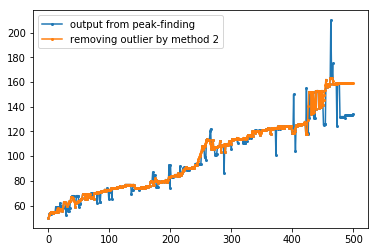

In [35]:
peak_pos = np.array(peak_idx_df.iloc[:, 0])
outlier_interp = id_outliers_replacewith_interp(datatime, peak_pos, 1, 25)
plt.figure
plt.plot(datatime, peak_pos, '-o', markersize = 2, label = 'output from peak-finding')

plt.plot(datatime, outlier_interp, '-o', markersize = 2, label = 'removing outlier by method 2')
#plt.plot(datatime, peak_pos_true, '-o', markersize = 2, label = 'true peak position')
plt.legend()

10


/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


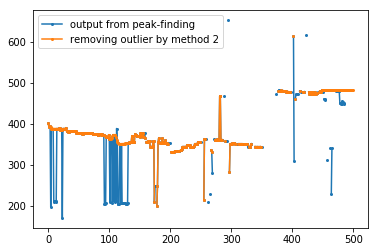

In [59]:
peak_pos_2 = np.array(peak_idx_df.iloc[:, 1])
outlier_interp_2 = id_outliers_replacewith_interp(datatime, peak_pos_2, 1, 50)
plt.figure
plt.plot(datatime, peak_pos_2, '-o', markersize = 2, label = 'output from peak-finding')

plt.plot(datatime, outlier_interp_2, '-o', markersize = 2, label = 'removing outlier by method 2')
#plt.plot(datatime, peak_pos_true, '-o', markersize = 2, label = 'true peak position')
plt.legend()

In [60]:
peak_idx_df.iloc[:, 0] = outlier_interp
peak_idx_df.iloc[:, 1] = outlier_interp_2

In [61]:
first_comp = np.array([[peak_idx_df.loc[i][0], peak_height_df.loc[i][0], peak_fwhm_df.loc[i][0], i] for i in range(500)])
sec_comp = np.append(first_comp, [[peak_idx_df.loc[i][1], peak_height_df.loc[i][1], peak_fwhm_df.loc[i][1], i] for i in range(500)], axis=0)
all_points = np.append(sec_comp, [[peak_idx_df.loc[i][2], peak_height_df.loc[i][2], peak_fwhm_df.loc[i][2], i] for i in range(500)], axis=0)
np.shape(all_points)

(1500, 4)

In [62]:
all_points_df = pd.DataFrame(all_points, columns=['Position', 'Height', 'Width', 'Time'])
all_points_df.describe()

,Position,Height,Width,Time
count,918.000000,927.000000,927.000000,1500.000000
mean,232.358388,0.232707,163.016181,249.500000
std,150.150646,0.245998,78.018901,144.385415
min,50.000000,-0.000801,1.000000,0.000000
25%,90.000000,0.059162,117.500000,124.750000
50%,158.000000,0.138727,130.000000,249.500000
75%,369.000000,0.295050,197.500000,374.250000
max,650.000000,0.996078,419.000000,499.000000


In [63]:
all_points_df

,Position,Height,Width,Time
0,50.0,0.985774,110.0,0.0
1,52.0,0.996078,111.0,1.0
2,54.0,0.990876,111.0,2.0
3,54.0,0.986697,111.0,3.0
4,54.5,0.980665,112.0,4.0
5,55.0,0.977614,110.0,5.0
6,55.0,0.972848,110.0,6.0
7,54.0,0.970956,111.0,7.0
8,54.0,0.970788,110.0,8.0
9,55.0,0.957124,112.0,9.0


In [64]:
corrected_output = all_points_df.fillna(value=0)

In [65]:
all_points_df.describe()

,Position,Height,Width,Time
count,918.000000,927.000000,927.000000,1500.000000
mean,232.358388,0.232707,163.016181,249.500000
std,150.150646,0.245998,78.018901,144.385415
min,50.000000,-0.000801,1.000000,0.000000
25%,90.000000,0.059162,117.500000,124.750000
50%,158.000000,0.138727,130.000000,249.500000
75%,369.000000,0.295050,197.500000,374.250000
max,650.000000,0.996078,419.000000,499.000000


In [66]:
corrected_output.describe()

,Position,Height,Width,Time
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,142.203333,0.143813,100.744000,249.500000
std,163.158630,0.223999,100.189406,144.385415
min,0.000000,-0.000801,0.000000,0.000000
25%,0.000000,0.000000,0.000000,124.750000
50%,77.000000,0.044437,116.000000,249.500000
75%,345.000000,0.188971,136.000000,374.250000
max,650.000000,0.996078,419.000000,499.000000


In [67]:
corrected_output.iloc[:,:-1]

,Position,Height,Width
0,50.0,0.985774,110.0
1,52.0,0.996078,111.0
2,54.0,0.990876,111.0
3,54.0,0.986697,111.0
4,54.5,0.980665,112.0
5,55.0,0.977614,110.0
6,55.0,0.972848,110.0
7,54.0,0.970956,111.0
8,54.0,0.970788,110.0
9,55.0,0.957124,112.0


In [68]:
cluster = KMeans(n_clusters=3).fit(corrected_output.iloc[:,:-1])
cluster.labels_

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

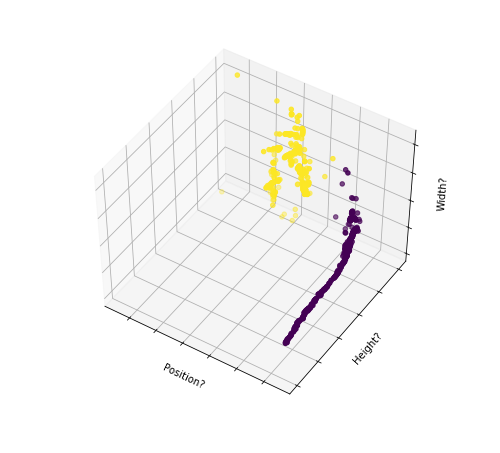

In [69]:
fignum = 1
fig = plt.figure(fignum, figsize=(7, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=50, azim=123)
cluster
labels = cluster.labels_

ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2],
             c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Position?')
ax.set_ylabel('Height?')
ax.set_zlabel('Width?')
ax.dist = 12

In [70]:
peak1_list = []
peak2_list = []
peak3_list = []

for i in range(1500):
    peak = cluster.predict([corrected_output.iloc[i,:-1]])
    signal = corrected_output.iloc[i][1]
    if ( peak == 0 and (signal >= 0.001 or signal <= -0.001)):
        peak1_list.append(corrected_output.iloc[i])
    elif ( peak == 1 and (signal >= 0.001 or signal <= -0.001)):
        peak2_list.append(corrected_output.iloc[i])
    elif ( peak == 2 and (signal >= 0.001 or signal <= -0.001)):
        peak3_list.append(corrected_output.iloc[i])
    else:
        pass

In [71]:
peak1_unfilt = pd.DataFrame(peak1_list, columns=['Position', 'Height', 'Width', 'Time'])
peak1 = peak1_unfilt.drop_duplicates(subset='Time')

peak2_unfilt = pd.DataFrame(peak2_list, columns=['Position', 'Height', 'Width', 'Time'])
peak2 = peak2_unfilt.drop_duplicates(subset='Time')

peak3_unfilt = pd.DataFrame(peak3_list, columns=['Position', 'Height', 'Width', 'Time'])
peak3 = peak3_unfilt.drop_duplicates(subset='Time')

In [72]:
peak1.describe()

,Position,Height,Width,Time
count,500.000000,500.000000,500.000000,500.000000
mean,101.182000,0.368152,125.882000,249.500000
std,30.862105,0.260528,16.034284,144.481833
min,50.000000,0.075305,91.000000,0.000000
25%,74.000000,0.151585,116.000000,124.750000
50%,102.500000,0.273950,125.000000,249.500000
75%,122.125000,0.560763,132.000000,374.250000
max,163.000000,0.996078,314.000000,499.000000


In [73]:
peak2.describe()

,Position,Height,Width,Time
count,303.000000,303.000000,303.000000,303.000000
mean,367.983498,0.087227,232.643564,167.148515
std,32.124620,0.070968,89.996974,111.634994
min,248.000000,0.001134,34.000000,0.000000
25%,352.000000,0.038155,157.000000,75.500000
50%,362.000000,0.061762,228.000000,151.000000
75%,377.000000,0.119620,291.000000,240.500000
max,614.000000,0.299023,419.000000,465.000000


In [74]:
peak3.describe()

,Position,Height,Width,Time
count,1.0,1.000000,1.0,1.0
mean,0.0,0.091006,26.0,262.0
std,NaN,NaN,NaN,NaN
min,0.0,0.091006,26.0,262.0
25%,0.0,0.091006,26.0,262.0
50%,0.0,0.091006,26.0,262.0
75%,0.0,0.091006,26.0,262.0
max,0.0,0.091006,26.0,262.0


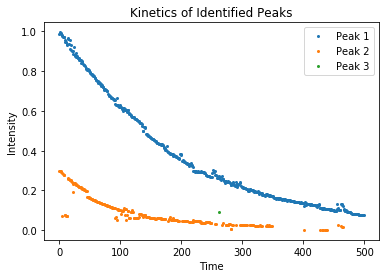

In [76]:
plt.plot(peak1['Time'], peak1['Height'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak2['Time'], peak2['Height'], 'o', markersize = 2, label = 'Peak 2')
plt.plot(peak3['Time'], peak3['Height'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Kinetics of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

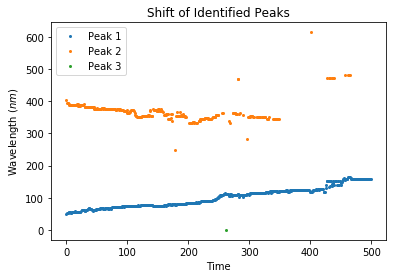

In [78]:
plt.plot(peak1['Time'], peak1['Position'], 'o', markersize = 2, label = 'Peak 1')
plt.plot(peak2['Time'], peak2['Position'], 'o', markersize = 2, label = 'Peak 2')
plt.plot(peak3['Time'], peak3['Position'], 'o', markersize = 2, label = 'Peak 3')
plt.title('Shift of Identified Peaks')
plt.xlabel('Time')
plt.ylabel('Wavelength $(nm)$')
plt.legend()
plt.show()

In [79]:
def singleexpfunc(t, params):
    exp_array = params[0] *np.exp((-1.0/params[1]) * t)

    return exp_array

def fit_single_exp_diffev(t, data, bounds):
    time_array = t
    data_array = data
    def fit(params):
        decaymodel = singleexpfunc(time_array, params[:])
        cost = np.sum(((data_array - decaymodel) ** 2.0))
        return cost
    bestfit = differential_evolution(fit, bounds = bounds, polish = True)
    bestfit_params = bestfit.x
    def bestfit_decay(params):
        decaymodel = singleexpfunc(time_array, params[:])
        return decaymodel    
    bestfit_model = bestfit_decay(bestfit_params)   
    
    ss_res = np.sum((data_array - bestfit_model) ** 2.0)
    ss_tot = np.sum((data_array - np.mean(data_array)) ** 2.0)
    rsquare = 1 - (ss_res / ss_tot)
    #print '--Single exponential best fit parameters--'
    print ('a = %.5f  \ntau = %.5f ps  \nR-square = %.5f' %(bestfit_params[0], bestfit_params[1], rsquare))
    plt.figure()
    plt.ylabel('-$\Delta$T/T')   
    plt.xlabel('Time (ps)')

    plt.plot(time_array, data_array, 'o', color = 'b', label = 'Data')
    plt.plot(time_array, bestfit_model, color = 'r', label = 'Monoexponential')
#    plt.text(10, 0.002, 'tau = 3ps', fontsize = 14)

    plt.legend(loc = 'best')

    plt.figure()
    #plt.xlim(0, 200)
    plt.ylabel('-$\Delta$T/T')   
    plt.xlabel('Time (ps)')
    plt.xscale('log')    
    plt.plot(time_array, data_array, 'o', color = 'b', label = 'Data')
    plt.plot(time_array, bestfit_model, color = 'r', label = 'single exp fit')
    plt.legend(loc = 'best')

    return bestfit_params, bestfit_model, data_array, time_array

a = 1.02272  
tau = 194.34686 ps  
R-square = 0.99791


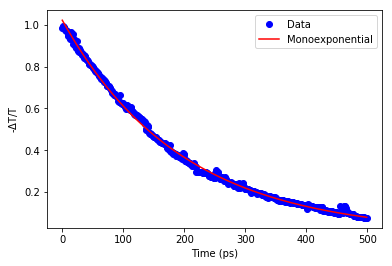

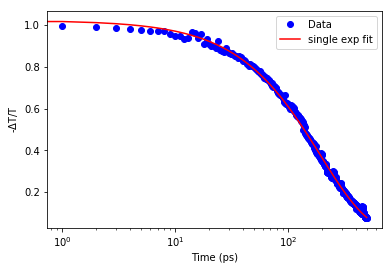

In [80]:
"""load TA data"""
#experiment name
experiment = ''

times, decaytrace = peak1['Time'], peak1['Height']



"""exponential decay parameters"""
a1_bounds = (0, 2)
tau1_bounds = (0, 1000)
beta1_bounds = (0,1)

sing_expdec_bounds = [a1_bounds, tau1_bounds]
exp_stret_bounds = [a1_bounds, tau1_bounds, beta1_bounds]



"""fit data"""
fit_data_sing_expdec = fit_single_exp_diffev(times, decaytrace, sing_expdec_bounds)

#fit_data_exp_stretch = fit_exp_stretch_diffev(times, decaytrace, exp_stret_bounds)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


a = 0.10427  
tau = 1925.36417 ps  
R-square = nan


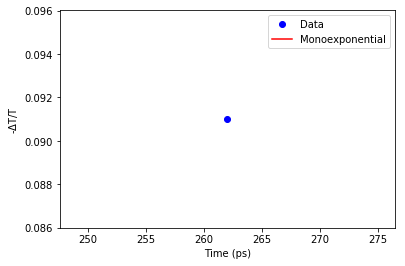

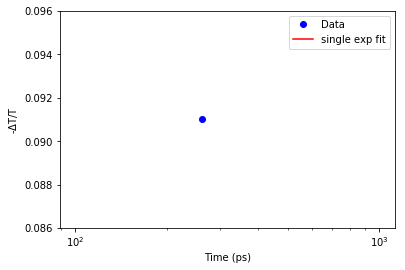

In [81]:
"""load TA data"""
#experiment name
experiment = ''

times, decaytrace = peak3['Time'], peak3['Height']



"""exponential decay parameters"""
a1_bounds = (0, 2)
tau1_bounds = (0, 10000)
beta1_bounds = (0,1)

sing_expdec_bounds = [a1_bounds, tau1_bounds]
exp_stret_bounds = [a1_bounds, tau1_bounds, beta1_bounds]



"""fit data"""
fit_data_sing_expdec = fit_single_exp_diffev(times, decaytrace, sing_expdec_bounds)

#fit_data_exp_stretch = fit_exp_stretch_diffev(times, decaytrace, exp_stret_bounds)